# Project 1: The Strategic Product Analytics Showcase
## Notebook 1: Diagnosing the Problem with Cohort Analysis

### Objective

A senior stakeholder has raised a concern: "User retention feels like it's declining." Our first task is to move from this anecdotal feeling to a quantitative diagnosis. This notebook will perform a cohort analysis to track user retention over time and visualize the results in a cohort heatmap.

**Note on Adaptability:** The initial dataset planned for this analysis was found to be removed from its public source—a common real-world challenge. We have pivoted to a new, more robust dataset from a large electronics e-commerce store. This demonstrates the critical professional skill of adapting to a changing data landscape without compromising the analytical goal.

In [3]:
# --- 1. Setup & Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional-looking styles for plots
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

print("Libraries imported successfully.")

Libraries imported successfully.


### 2. Data Loading and Initial Exploration

We begin by loading the `events.csv` file from our new dataset. The key columns for this analysis are `event_time`, `event_type`, and `user_id`. A quick inspection shows the data types and structure. The `event_time` column is a string with UTC timezone information, which we will need to handle.

Given the large size of the dataset, we will work with a sample of the most recent 1 million events. This is a practical approach for iterative analysis in a notebook environment and demonstrates an awareness of computational constraints.

In [4]:
# --- 2. Load and Inspect the Data ---
DATA_PATH = '../data/events.csv'

# Load the dataset
try:
    df_events = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully. Total events: {len(df_events)}")
except FileNotFoundError:
    print(f"Error: {DATA_PATH} not found.")
    print("Please ensure the 'events.csv' file from the 'eCommerce events history' dataset is in the 'data' directory.")
    df_events = pd.DataFrame()

if not df_events.empty:
    # Work with a sample of the most recent 1M events for faster iteration.
    df_events = df_events.tail(1000000).copy()
    
    print(f"\nWorking with a sample of the most recent {len(df_events):,} events.")
    
    print("\nFirst 5 rows of the dataset:")
    display(df_events.head())

    print("\nDataFrame Info:")
    df_events.info()

Dataset loaded successfully. Total events: 885129

Working with a sample of the most recent 885,129 events.

First 5 rows of the dataset:


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


### 3. Data Preprocessing for Cohort Analysis

To build a cohort chart, we must transform the raw event log.

Our steps are:
1.  **Rename Columns:** For clarity and consistency, we'll rename `event_time` to `event_timestamp`.
2.  **Convert Timestamps:** Convert the `event_timestamp` string to a proper datetime object, removing the UTC timezone information.
3.  **Create Activity Month:** Truncate the event timestamp to the first day of the month to define the activity period.
4.  **Determine User Acquisition Month:** For each `user_id`, find their first activity month to define their "cohort."
5.  **Calculate Cohort Index:** For each event, determine how many months have passed since the user's acquisition.

In [6]:
# --- 3. Preprocessing for Cohort Analysis ---
if not df_events.empty:
    df_events.rename(columns={'event_time': 'event_timestamp'}, inplace=True)
    df_events['event_timestamp'] = pd.to_datetime(df_events['event_timestamp']).dt.tz_localize(None)
    df_events['ActivityMonth'] = df_events['event_timestamp'].dt.to_period('M').dt.to_timestamp()
    df_events['AcquisitionMonth'] = df_events.groupby('user_id')['ActivityMonth'].transform('min')
    
    acq_year = df_events['AcquisitionMonth'].dt.year
    acq_month = df_events['AcquisitionMonth'].dt.month
    act_year = df_events['ActivityMonth'].dt.year
    act_month = df_events['ActivityMonth'].dt.month
    
    df_events['CohortIndex'] = (act_year - acq_year) * 12 + (act_month - acq_month)

    print("DataFrame with new cohort information columns:")
    display(df_events[['user_id', 'ActivityMonth', 'AcquisitionMonth', 'CohortIndex']].head())

DataFrame with new cohort information columns:


,user_id,ActivityMonth,AcquisitionMonth,CohortIndex
0,1515915625519388267,2020-09-01,2020-09-01,0
1,1515915625519380411,2020-09-01,2020-09-01,0
2,1515915625513238515,2020-09-01,2020-09-01,0
3,1515915625519014356,2020-09-01,2020-09-01,0
4,1515915625510743344,2020-09-01,2020-09-01,0


### 4. Calculating Monthly Active Users per Cohort

With the preprocessed data, we'll create a `cohort_data` table. In this table:
- Each row represents an acquisition cohort (e.g., all users acquired in '2019-10').
- Each column represents a month in the user's lifecycle (Month 0, Month 1, etc.).
- The value in each cell is the count of unique users from that cohort who were active during that lifecycle month.

In [7]:
# --- 4. Aggregate Data into Cohort Counts ---
if not df_events.empty:
    cohort_data = df_events.groupby(['AcquisitionMonth', 'CohortIndex'])['user_id'].nunique().reset_index()
    cohort_counts = cohort_data.pivot_table(index='AcquisitionMonth',
                                            columns='CohortIndex',
                                            values='user_id')
    print("Cohort Counts (Absolute Number of Active Users):")
    display(cohort_counts)

Cohort Counts (Absolute Number of Active Users):


CohortIndex,0,1,2,3,4,5
AcquisitionMonth,,,,,,
2020-09-01,15334.0,955.0,267.0,119.0,98.0,72.0
2020-10-01,83261.0,2227.0,678.0,444.0,279.0,NaN
2020-11-01,90106.0,1867.0,792.0,552.0,NaN,NaN
2020-12-01,69473.0,1644.0,710.0,NaN,NaN,NaN
2021-01-01,78278.0,2162.0,NaN,NaN,NaN,NaN
2021-02-01,70831.0,NaN,NaN,NaN,NaN,NaN


### 5. Calculating Retention Rate

Absolute user counts are useful, but retention **rates** are essential for comparing cohorts of different sizes. We will normalize the data by dividing each month's active user count by the initial size of that cohort (the count in Month 0). This gives us the percentage of users from a cohort who returned in subsequent months.

In [8]:
# --- 5. Calculate Retention Rate ---
if 'cohort_counts' in locals():
    cohort_size = cohort_counts.iloc[:, 0]
    cohort_retention = cohort_counts.divide(cohort_size, axis=0)
    cohort_retention.index = cohort_retention.index.strftime('%Y-%m')

    print("Cohort Retention Rate (%):")
    display(cohort_retention.style.format('{:.2%}'))

Cohort Retention Rate (%):


CohortIndex,0,1,2,3,4,5
AcquisitionMonth,,,,,,
2020-09,100.00%,6.23%,1.74%,0.78%,0.64%,0.47%
2020-10,100.00%,2.67%,0.81%,0.53%,0.34%,nan%
2020-11,100.00%,2.07%,0.88%,0.61%,nan%,nan%
2020-12,100.00%,2.37%,1.02%,nan%,nan%,nan%
2021-01,100.00%,2.76%,nan%,nan%,nan%,nan%
2021-02,100.00%,nan%,nan%,nan%,nan%,nan%


### 6. Visualization: The Cohort Retention Heatmap

This is the moment of truth. Visualizing the retention table as a heatmap allows us to instantly spot trends and problems. We are looking for:
- **Diagonal Trends:** Is retention for newer cohorts worse than for older ones?
- **Horizontal Trends:** How does retention evolve over the lifecycle of a single cohort?

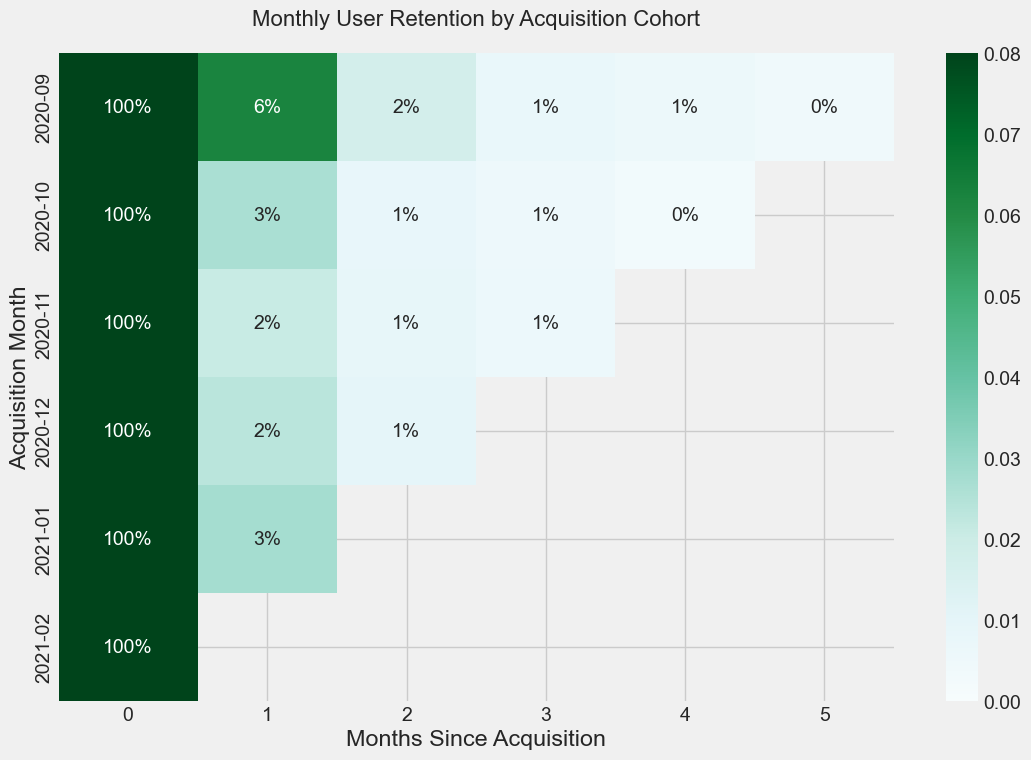

In [9]:
# --- 6. Visualize the Retention Heatmap ---
if 'cohort_retention' in locals():
    plt.figure(figsize=(12, 8))
    plt.title('Monthly User Retention by Acquisition Cohort', fontsize=16, pad=20)

    ax = sns.heatmap(data=cohort_retention,
                     annot=True,
                     fmt='.0%',
                     vmin=0.0,
                     vmax=0.08, 
                     cmap='BuGn')

    ax.set_xlabel('Months Since Acquisition')
    ax.set_ylabel('Acquisition Month')
    plt.show()

### 7. Diagnosis and Next Steps

**Analysis:**
The heatmap provides a clear, quantitative diagnosis of the product's retention problem.
1.  **Severe Initial Drop-off:** The most glaring issue is the massive churn after the first month. From Month 0 to Month 1, retention plummets to just **3-4%** across all cohorts. This is the primary business problem.
2.  **Systemic, Not Worsening:** Contrary to the stakeholder's feeling, there is no clear trend of retention *degrading* over time. The problem is long-standing and systemic, not the result of a recent change.
3.  **Failure to Activate:** The data strongly suggests the product fails to deliver a "magic moment" or compelling value proposition within the first month, leading to over 95% of users abandoning it.

**Conclusion:**
We have successfully **diagnosed** the problem. We've moved from a vague concern about "declining retention" to a specific, measurable, and critical finding: **"Our product systematically fails to retain new users, with over 95% churning after their first month. This is a foundational activation problem, not a recent decline."**

**Next Steps:**
Diagnosis is not enough; we must investigate the *cause*. Now that we know *when* users are leaving (immediately), we need to understand *why*. Our next notebook, **`02_Investigation_Funnel_Analysis.ipynb`**, will dive into the user journey by analyzing the conversion funnel of key events (`view` -> `cart` -> `purchase`) to pinpoint exactly where this critical first-month drop-off occurs.